In [24]:
!git clone https://github.com/JPortilloHub/miningAgent.git
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import plotly.express as px
from plotly.subplots import make_subplots
import networkx as nx
import re
import csv
from collections import defaultdict, Counter
from datetime import timedelta
import warnings
warnings.filterwarnings('ignore')

fatal: destination path 'miningAgent' already exists and is not an empty directory.


In [27]:
class ProcessMiningTool:
    """
    A comprehensive process mining tool for analyzing AI agent execution logs.
    Produces workflow visualizations with timing metrics and KPI statistics.
    Includes variant analysis, bottleneck detection, and interactive visualizations.
    """

    def __init__(self, data):
        """
        Initialize the tool and load data.

        Args:
            data: Either a pandas DataFrame, a list of dictionaries (from csv.DictReader),
                  or a string path to a CSV file.
        """
        if isinstance(data, pd.DataFrame):
            self.df = data.copy()
        elif isinstance(data, list) and len(data) > 0 and isinstance(data[0], dict):
            # Convert list of dictionaries to DataFrame
            self.df = pd.DataFrame(data)
        elif isinstance(data, str):
            # Assume it's a file path
            self.df = pd.read_csv(data)
        else:
            raise ValueError("Input must be a DataFrame, list of dictionaries, or CSV file path")

        self.preprocess_data()
        self.transitions = None
        self.kpis = None
        self.variants = None
        self.bottlenecks = None

    def preprocess_data(self):
        """Preprocess timestamps and sort data."""
        # Normalize column names to lowercase for consistency
        self.df.columns = self.df.columns.str.lower().str.strip()

        # Convert timestamp to datetime
        self.df['timestamp'] = pd.to_datetime(self.df['timestamp'])

        # Sort by caseid and timestamp
        self.df = self.df.sort_values(['caseid', 'timestamp']).reset_index(drop=True)

        # Display data overview
        print(f"✓ Loaded {len(self.df)} events from {self.df['caseid'].nunique()} cases")
        print(f"✓ Date range: {self.df['timestamp'].min()} to {self.df['timestamp'].max()}")
        print(f"✓ Unique actions: {self.df['action'].nunique()}")
        print(f"\n📋 Action distribution:")
        for action, count in self.df['action'].value_counts().items():
            print(f"   • {action}: {count}")

    def compute_kpis(self):
        """Compute case-level KPIs."""
        case_durations = []
        case_activity_counts = []

        for caseid, group in self.df.groupby('caseid'):
            min_time = group['timestamp'].min()
            max_time = group['timestamp'].max()
            duration = (max_time - min_time).total_seconds()
            case_durations.append(duration)
            case_activity_counts.append(len(group))

        self.kpis = {
            'total_cases': len(case_durations),
            'total_events': len(self.df),
            'avg_duration_seconds': np.mean(case_durations),
            'median_duration_seconds': np.median(case_durations),
            'min_duration_seconds': np.min(case_durations),
            'max_duration_seconds': np.max(case_durations),
            'std_duration_seconds': np.std(case_durations),
            'avg_activities_per_case': np.mean(case_activity_counts),
            'median_activities_per_case': np.median(case_activity_counts)
        }

        return self.kpis

    def extract_transitions(self):
        """Extract all transitions between actions with timing information."""
        transitions = []

        for caseid, group in self.df.groupby('caseid'):
            actions = group['action'].tolist()
            timestamps = group['timestamp'].tolist()

            # Only process cases with at least 2 actions
            if len(actions) < 2:
                print(f"⚠️  Warning: Case {caseid} has only {len(actions)} action(s), skipping transitions")
                continue

            for i in range(len(actions) - 1):
                source = actions[i]
                target = actions[i + 1]
                duration = (timestamps[i + 1] - timestamps[i]).total_seconds()

                transitions.append({
                    'source': source,
                    'target': target,
                    'duration': duration,
                    'caseid': caseid
                })

        self.transitions = pd.DataFrame(transitions)

        if len(self.transitions) == 0:
            print("⚠️  No transitions found in the data!")
        else:
            print(f"✓ Extracted {len(self.transitions)} transitions")

        return self.transitions

    def compute_transition_metrics(self):
        """Aggregate transition metrics (average duration and count)."""
        if self.transitions is None:
            self.extract_transitions()

        metrics = self.transitions.groupby(['source', 'target']).agg({
            'duration': ['mean', 'median', 'std', 'min', 'max', 'count']
        }).reset_index()

        metrics.columns = ['source', 'target', 'avg_duration', 'median_duration',
                          'std_duration', 'min_duration', 'max_duration', 'count']
        return metrics

    def analyze_variants(self):
        """Analyze process variants (unique paths through the process)."""
        variants = []

        for caseid, group in self.df.groupby('caseid'):
            actions = group['action'].tolist()
            variant = ' → '.join(actions)

            min_time = group['timestamp'].min()
            max_time = group['timestamp'].max()
            duration = (max_time - min_time).total_seconds()

            variants.append({
                'caseid': caseid,
                'variant': variant,
                'duration': duration,
                'num_activities': len(actions)
            })

        self.variants = pd.DataFrame(variants)

        # Compute variant statistics
        variant_stats = self.variants.groupby('variant').agg({
            'caseid': 'count',
            'duration': ['mean', 'median', 'std'],
            'num_activities': 'first'
        }).reset_index()

        variant_stats.columns = ['variant', 'frequency', 'avg_duration',
                                'median_duration', 'std_duration', 'num_activities']
        variant_stats = variant_stats.sort_values('frequency', ascending=False)
        variant_stats['percentage'] = (variant_stats['frequency'] / len(self.variants) * 100).round(2)

        return variant_stats

    def detect_bottlenecks(self, threshold_percentile=75):
        """
        Detect bottlenecks based on transition duration.

        Args:
            threshold_percentile: Percentile threshold for identifying slow transitions (default 75)
        """
        if self.transitions is None:
            self.extract_transitions()

        metrics = self.compute_transition_metrics()

        # Calculate threshold
        duration_threshold = self.transitions['duration'].quantile(threshold_percentile / 100)

        # Identify bottlenecks
        bottlenecks = metrics[metrics['avg_duration'] > duration_threshold].copy()
        bottlenecks = bottlenecks.sort_values('avg_duration', ascending=False)

        # Calculate variability (coefficient of variation)
        bottlenecks['cv'] = bottlenecks['std_duration'] / bottlenecks['avg_duration']

        self.bottlenecks = bottlenecks

        return bottlenecks

    @staticmethod
    def format_duration(seconds):
        """Format duration in human-readable form."""
        if seconds < 1:
            return f"{seconds*1000:.0f}ms"
        elif seconds < 60:
            return f"{seconds:.1f}s"
        elif seconds < 3600:
            return f"{seconds/60:.1f}m"
        elif seconds < 86400:
            return f"{seconds/3600:.1f}h"
        else:
            return f"{seconds/86400:.1f}d"

    def build_process_graph(self):
        """Build a directed graph representing the process flow."""
        metrics = self.compute_transition_metrics()

        G = nx.DiGraph()

        # Add all unique actions as nodes
        all_actions = set(metrics['source'].unique()) | set(metrics['target'].unique())
        G.add_nodes_from(all_actions)

        # Add edges with attributes
        for _, row in metrics.iterrows():
            avg_dur_formatted = self.format_duration(row['avg_duration'])
            edge_label = f"{avg_dur_formatted} / {int(row['count'])}"

            G.add_edge(
                row['source'],
                row['target'],
                weight=row['count'],
                avg_duration=row['avg_duration'],
                median_duration=row['median_duration'],
                label=edge_label
            )

        return G

    def visualize_workflow_static(self, figsize=(16, 12), output_path=None):
        """Create a static workflow visualization with matplotlib."""
        G = self.build_process_graph()

        # Create figure
        fig, ax = plt.subplots(figsize=figsize)

        # Use hierarchical layout for better readability
        try:
            pos = nx.spring_layout(G, k=2, iterations=50, seed=42)
        except:
            pos = nx.shell_layout(G)

        # Calculate node sizes based on frequency
        node_frequencies = defaultdict(int)
        for edge in G.edges():
            node_frequencies[edge[0]] += G.edges[edge]['weight']
            node_frequencies[edge[1]] += G.edges[edge]['weight']

        max_freq = max(node_frequencies.values()) if node_frequencies else 1
        node_sizes = [3000 + (node_frequencies[node] / max_freq) * 5000 for node in G.nodes()]

        # Draw nodes
        nx.draw_networkx_nodes(
            G, pos,
            node_size=node_sizes,
            node_color='lightblue',
            edgecolors='darkblue',
            linewidths=2,
            ax=ax
        )

        # Draw edges with varying thickness
        edge_weights = [G.edges[edge]['weight'] for edge in G.edges()]
        max_weight = max(edge_weights) if edge_weights else 1
        edge_widths = [1 + (w / max_weight) * 4 for w in edge_weights]

        nx.draw_networkx_edges(
            G, pos,
            width=edge_widths,
            edge_color='gray',
            arrows=True,
            arrowsize=20,
            arrowstyle='->',
            connectionstyle='arc3,rad=0.1',
            ax=ax
        )

        # Draw node labels
        nx.draw_networkx_labels(
            G, pos,
            font_size=10,
            font_weight='bold',
            font_color='darkblue',
            ax=ax
        )

        # Draw edge labels
        edge_labels = nx.get_edge_attributes(G, 'label')
        nx.draw_networkx_edge_labels(
            G, pos,
            edge_labels=edge_labels,
            font_size=8,
            font_color='red',
            bbox=dict(boxstyle='round,pad=0.3', facecolor='white', edgecolor='none', alpha=0.7),
            ax=ax
        )

        ax.set_title('AI Agent Process Flow\n(Edge labels: avg_duration / occurrence_count)',
                     fontsize=16, fontweight='bold', pad=20)
        ax.axis('off')
        plt.tight_layout()

        if output_path:
            plt.savefig(output_path, dpi=300, bbox_inches='tight')
            print(f"✓ Static workflow visualization saved to {output_path}")

        plt.show()

        return G

    def visualize_workflow_interactive(self, output_path='workflow_interactive.html'):
        """Create an interactive workflow visualization with Plotly."""
        G = self.build_process_graph()
        metrics = self.compute_transition_metrics()

        # Calculate positions
        try:
            pos = nx.spring_layout(G, k=2, iterations=50, seed=42)
        except:
            pos = nx.shell_layout(G)

        # Calculate node frequencies
        node_frequencies = defaultdict(int)
        for edge in G.edges():
            node_frequencies[edge[0]] += G.edges[edge]['weight']
            node_frequencies[edge[1]] += G.edges[edge]['weight']

        # Create edge traces
        edge_traces = []
        for edge in G.edges():
            x0, y0 = pos[edge[0]]
            x1, y1 = pos[edge[1]]

            weight = G.edges[edge]['weight']
            avg_dur = G.edges[edge]['avg_duration']
            median_dur = G.edges[edge]['median_duration']

            edge_trace = go.Scatter(
                x=[x0, x1, None],
                y=[y0, y1, None],
                mode='lines',
                line=dict(
                    width=1 + (weight / max([G.edges[e]['weight'] for e in G.edges()]) * 5),
                    color='gray'
                ),
                hoverinfo='text',
                text=f"{edge[0]} → {edge[1]}<br>" +
                     f"Frequency: {weight}<br>" +
                     f"Avg Duration: {self.format_duration(avg_dur)}<br>" +
                     f"Median Duration: {self.format_duration(median_dur)}",
                showlegend=False
            )
            edge_traces.append(edge_trace)

        # Create node trace
        node_x = []
        node_y = []
        node_text = []
        node_size = []

        for node in G.nodes():
            x, y = pos[node]
            node_x.append(x)
            node_y.append(y)
            freq = node_frequencies[node]
            node_size.append(20 + (freq / max(node_frequencies.values()) * 40))
            node_text.append(f"{node}<br>Frequency: {freq}")

        node_trace = go.Scatter(
            x=node_x,
            y=node_y,
            mode='markers+text',
            text=[node for node in G.nodes()],
            textposition='top center',
            hoverinfo='text',
            hovertext=node_text,
            marker=dict(
                size=node_size,
                color='lightblue',
                line=dict(width=2, color='darkblue')
            ),
            showlegend=False
        )

        # Create figure
        fig = go.Figure(data=edge_traces + [node_trace])

        fig.update_layout(
            title='Interactive AI Agent Process Flow<br><sub>Hover over nodes and edges for details</sub>',
            showlegend=False,
            hovermode='closest',
            xaxis=dict(showgrid=False, zeroline=False, showticklabels=False),
            yaxis=dict(showgrid=False, zeroline=False, showticklabels=False),
            plot_bgcolor='white',
            width=1200,
            height=800
        )

        fig.write_html(output_path)
        print(f"✓ Interactive workflow visualization saved to {output_path}")

        return fig

    def visualize_variants(self, top_n=10, output_path='variants_analysis.html'):
        """Create interactive variant analysis visualization."""
        if self.variants is None:
            variant_stats = self.analyze_variants()
        else:
            variant_stats = self.analyze_variants()

        # Prepare data for top N variants
        top_variants = variant_stats.head(top_n)

        # Create subplots
        fig = make_subplots(
            rows=2, cols=2,
            subplot_titles=(
                'Top Process Variants by Frequency',
                'Variant Duration Distribution',
                'Variant Frequency vs Duration',
                'Cumulative Frequency'
            ),
            specs=[[{"type": "bar"}, {"type": "box"}],
                   [{"type": "scatter"}, {"type": "scatter"}]]
        )

        # 1. Frequency bar chart
        fig.add_trace(
            go.Bar(
                x=[f"V{i+1}" for i in range(len(top_variants))],
                y=top_variants['frequency'],
                text=top_variants['percentage'].apply(lambda x: f"{x}%"),
                textposition='auto',
                hovertext=[f"{v}<br>Frequency: {f} ({p}%)"
                          for v, f, p in zip(top_variants['variant'],
                                            top_variants['frequency'],
                                            top_variants['percentage'])],
                hoverinfo='text',
                marker_color='lightblue'
            ),
            row=1, col=1
        )

        # 2. Duration box plot
        variant_durations = []
        variant_labels = []
        for i, (_, row) in enumerate(top_variants.iterrows()):
            durations = self.variants[self.variants['variant'] == row['variant']]['duration'].values
            variant_durations.extend(durations)
            variant_labels.extend([f"V{i+1}"] * len(durations))

        fig.add_trace(
            go.Box(
                y=variant_durations,
                x=variant_labels,
                marker_color='lightgreen'
            ),
            row=1, col=2
        )

        # 3. Frequency vs Duration scatter
        fig.add_trace(
            go.Scatter(
                x=top_variants['frequency'],
                y=top_variants['avg_duration'],
                mode='markers+text',
                text=[f"V{i+1}" for i in range(len(top_variants))],
                textposition='top center',
                marker=dict(size=12, color='coral'),
                hovertext=[f"{v}<br>Freq: {f}<br>Avg Duration: {self.format_duration(d)}"
                          for v, f, d in zip(top_variants['variant'],
                                            top_variants['frequency'],
                                            top_variants['avg_duration'])],
                hoverinfo='text'
            ),
            row=2, col=1
        )

        # 4. Cumulative frequency
        cumsum = top_variants['percentage'].cumsum()
        fig.add_trace(
            go.Scatter(
                x=[f"V{i+1}" for i in range(len(top_variants))],
                y=cumsum,
                mode='lines+markers',
                marker=dict(size=8, color='purple'),
                line=dict(width=2),
                fill='tonexty',
                hovertext=[f"Cumulative: {c:.1f}%" for c in cumsum],
                hoverinfo='text'
            ),
            row=2, col=2
        )

        # Update layout
        fig.update_xaxes(title_text="Variant", row=1, col=1)
        fig.update_yaxes(title_text="Frequency", row=1, col=1)

        fig.update_xaxes(title_text="Variant", row=1, col=2)
        fig.update_yaxes(title_text="Duration (seconds)", row=1, col=2)

        fig.update_xaxes(title_text="Frequency", row=2, col=1)
        fig.update_yaxes(title_text="Avg Duration (seconds)", row=2, col=1)

        fig.update_xaxes(title_text="Variant", row=2, col=2)
        fig.update_yaxes(title_text="Cumulative %", row=2, col=2)

        fig.update_layout(
            title_text=f"Process Variant Analysis (Top {top_n})",
            showlegend=False,
            height=900,
            width=1400
        )

        fig.write_html(output_path)
        print(f"✓ Variant analysis visualization saved to {output_path}")

        return fig

    def visualize_bottlenecks(self, output_path='bottlenecks_analysis.html'):
        """Create interactive bottleneck analysis visualization."""
        if self.bottlenecks is None:
            self.detect_bottlenecks()

        # Create figure
        fig = make_subplots(
            rows=2, cols=1,
            subplot_titles=(
                'Bottleneck Transitions (Sorted by Average Duration)',
                'Duration Variability Analysis'
            ),
            row_heights=[0.6, 0.4]
        )

        # 1. Bottleneck bar chart
        bottlenecks_sorted = self.bottlenecks.sort_values('avg_duration', ascending=True)
        transition_labels = [f"{s} → {t}" for s, t in zip(bottlenecks_sorted['source'],
                                                           bottlenecks_sorted['target'])]

        fig.add_trace(
            go.Bar(
                y=transition_labels,
                x=bottlenecks_sorted['avg_duration'],
                orientation='h',
                marker=dict(
                    color=bottlenecks_sorted['avg_duration'],
                    colorscale='Reds',
                    showscale=True,
                    colorbar=dict(title="Duration (s)")
                ),
                text=[self.format_duration(d) for d in bottlenecks_sorted['avg_duration']],
                textposition='auto',
                hovertext=[f"{s} → {t}<br>" +
                          f"Avg: {self.format_duration(avg)}<br>" +
                          f"Median: {self.format_duration(med)}<br>" +
                          f"Min: {self.format_duration(min_d)}<br>" +
                          f"Max: {self.format_duration(max_d)}<br>" +
                          f"Count: {cnt}"
                          for s, t, avg, med, min_d, max_d, cnt in
                          zip(bottlenecks_sorted['source'], bottlenecks_sorted['target'],
                              bottlenecks_sorted['avg_duration'], bottlenecks_sorted['median_duration'],
                              bottlenecks_sorted['min_duration'], bottlenecks_sorted['max_duration'],
                              bottlenecks_sorted['count'])],
                hoverinfo='text'
            ),
            row=1, col=1
        )

        # 2. Variability scatter plot
        fig.add_trace(
            go.Scatter(
                x=bottlenecks_sorted['avg_duration'],
                y=bottlenecks_sorted['cv'],
                mode='markers+text',
                text=[f"{s[:10]}→{t[:10]}" for s, t in zip(bottlenecks_sorted['source'],
                                                             bottlenecks_sorted['target'])],
                textposition='top center',
                marker=dict(
                    size=bottlenecks_sorted['count'] / bottlenecks_sorted['count'].max() * 30 + 10,
                    color='coral',
                    line=dict(width=1, color='darkred')
                ),
                hovertext=[f"{s} → {t}<br>" +
                          f"Avg Duration: {self.format_duration(avg)}<br>" +
                          f"Std Dev: {self.format_duration(std)}<br>" +
                          f"CV: {cv:.2f}<br>" +
                          f"Count: {cnt}"
                          for s, t, avg, std, cv, cnt in
                          zip(bottlenecks_sorted['source'], bottlenecks_sorted['target'],
                              bottlenecks_sorted['avg_duration'], bottlenecks_sorted['std_duration'],
                              bottlenecks_sorted['cv'], bottlenecks_sorted['count'])],
                hoverinfo='text'
            ),
            row=2, col=1
        )

        # Update layout
        fig.update_xaxes(title_text="Average Duration (seconds)", row=1, col=1)
        fig.update_yaxes(title_text="Transition", row=1, col=1)

        fig.update_xaxes(title_text="Average Duration (seconds)", row=2, col=1)
        fig.update_yaxes(title_text="Coefficient of Variation (CV)", row=2, col=1)

        fig.update_layout(
            title_text="Bottleneck Analysis<br><sub>Higher CV indicates more variable transition times</sub>",
            showlegend=False,
            height=1000,
            width=1400
        )

        fig.write_html(output_path)
        print(f"✓ Bottleneck analysis visualization saved to {output_path}")

        return fig

    def print_kpi_report(self):
        """Print a formatted KPI report."""
        if self.kpis is None:
            self.compute_kpis()

        print("\n" + "="*60)
        print("📊 PROCESS MINING KPI REPORT")
        print("="*60)
        print(f"\n📁 Total Cases: {self.kpis['total_cases']}")
        print(f"📋 Total Events: {self.kpis['total_events']}")
        print(f"📈 Avg Activities per Case: {self.kpis['avg_activities_per_case']:.1f}")
        print(f"📉 Median Activities per Case: {self.kpis['median_activities_per_case']:.0f}")
        print(f"\n⏱️  Case Duration Statistics:")
        print(f"   • Average:  {self.format_duration(self.kpis['avg_duration_seconds'])}")
        print(f"   • Median:   {self.format_duration(self.kpis['median_duration_seconds'])}")
        print(f"   • Std Dev:  {self.format_duration(self.kpis['std_duration_seconds'])}")
        print(f"   • Minimum:  {self.format_duration(self.kpis['min_duration_seconds'])}")
        print(f"   • Maximum:  {self.format_duration(self.kpis['max_duration_seconds'])}")
        print("\n" + "="*60 + "\n")

    def print_transition_summary(self, top_n=10):
        """Print summary of most frequent transitions."""
        metrics = self.compute_transition_metrics()
        metrics_sorted = metrics.sort_values('count', ascending=False)

        print(f"\n🔄 Top {top_n} Most Frequent Transitions:")
        print("-" * 90)
        print(f"{'Source':<25} {'Target':<25} {'Avg Duration':<15} {'Count':<10}")
        print("-" * 90)

        for _, row in metrics_sorted.head(top_n).iterrows():
            duration_str = self.format_duration(row['avg_duration'])
            print(f"{row['source']:<25} {row['target']:<25} {duration_str:<15} {int(row['count']):<10}")

        print("-" * 90 + "\n")

    def print_variant_summary(self, top_n=5):
        """Print summary of process variants."""
        variant_stats = self.analyze_variants()

        print(f"\n🔀 Top {top_n} Process Variants:")
        print("="*100)

        for i, (_, row) in enumerate(variant_stats.head(top_n).iterrows(), 1):
            print(f"\nVariant {i} ({row['percentage']:.1f}% of cases, frequency: {int(row['frequency'])})")
            print(f"   Path: {row['variant']}")
            print(f"   Avg Duration: {self.format_duration(row['avg_duration'])}")
            print(f"   Activities: {int(row['num_activities'])}")

        print("\n" + "="*100 + "\n")

    def print_bottleneck_summary(self, top_n=5):
        """Print summary of detected bottlenecks."""
        if self.bottlenecks is None:
            self.detect_bottlenecks()

        print(f"\n🚨 Top {top_n} Bottlenecks (Slowest Transitions):")
        print("-" * 100)
        print(f"{'Transition':<40} {'Avg Duration':<15} {'Median':<15} {'Count':<10} {'CV':<10}")
        print("-" * 100)

        for _, row in self.bottlenecks.head(top_n).iterrows():
            transition = f"{row['source'][:15]} → {row['target'][:15]}"
            avg_str = self.format_duration(row['avg_duration'])
            med_str = self.format_duration(row['median_duration'])
            cv_str = f"{row['cv']:.2f}"

            print(f"{transition:<40} {avg_str:<15} {med_str:<15} {int(row['count']):<10} {cv_str:<10}")

        print("-" * 100)
        print("Note: CV (Coefficient of Variation) indicates duration variability. Higher = more variable.")
        print("-" * 100 + "\n")

    def run_complete_analysis(self,
                            static_output='agent_workflow_static.png',
                            interactive_output='agent_workflow_interactive.html',
                            variants_output='variants_analysis.html',
                            bottlenecks_output='bottlenecks_analysis.html'):
        """Run the complete process mining analysis pipeline."""
        print("\n🚀 Starting Comprehensive Process Mining Analysis...\n")

        # Compute KPIs
        self.compute_kpis()
        self.print_kpi_report()

        # Extract and summarize transitions
        self.extract_transitions()
        self.print_transition_summary()

        # Analyze variants
        self.print_variant_summary()

        # Detect bottlenecks
        self.detect_bottlenecks()
        self.print_bottleneck_summary()

        # Generate visualizations
        print("📈 Generating visualizations...\n")

        print("1️⃣ Creating static workflow diagram...")
        self.visualize_workflow_static(output_path=static_output)

        print("\n2️⃣ Creating interactive workflow diagram...")
        self.visualize_workflow_interactive(output_path=interactive_output)

        print("\n3️⃣ Creating variant analysis...")
        self.visualize_variants(output_path=variants_output)

        print("\n4️⃣ Creating bottleneck analysis...")
        self.visualize_bottlenecks(output_path=bottlenecks_output)

        print("\n✅ Complete Analysis Finished!")
        print(f"\n📂 Generated Files:")
        print(f"   • {static_output}")
        print(f"   • {interactive_output}")
        print(f"   • {variants_output}")
        print(f"   • {bottlenecks_output}")

        return self

In [13]:
all_logs

[{'action': 'Coverage inquiry initiated',
  'timestamp': '2025-11-26T16:58:52.097694',
  'caseId': '33737b97-d117-4872-815d-02ba8266a2cf',
  'tool_used': '{}',
  'comment': '{}'},
 {'action': 'Input message set',
  'timestamp': '2025-11-26T16:58:52.097752',
  'caseId': '33737b97-d117-4872-815d-02ba8266a2cf',
  'tool_used': '{}',
  'comment': '{}'},
 {'action': 'Patient Verification Completed',
  'timestamp': '2025-11-26T16:58:55.247982',
  'caseId': '33737b97-d117-4872-815d-02ba8266a2cf',
  'tool_used': 'Tool used: verify_patient',
  'comment': '{}'},
 {'action': 'Coverage Checked',
  'timestamp': '2025-11-26T16:58:58.799997',
  'caseId': '33737b97-d117-4872-815d-02ba8266a2cf',
  'tool_used': 'Tool used: check_coverage',
  'comment': '{}'},
 {'action': 'Covered',
  'timestamp': '2025-11-26T16:59:01.979638',
  'caseId': '33737b97-d117-4872-815d-02ba8266a2cf',
  'tool_used': 'Tool used: finalize_decision',
  'comment': 'decision: Covered'},
 {'action': 'Case closed',
  'timestamp': '2025

✓ Loaded 574 events from 115 cases
✓ Date range: 2025-11-26 16:58:52.097694 to 2025-11-26 17:23:02.478011
✓ Unique actions: 9

📋 Action distribution:
   • Coverage inquiry initiated: 115
   • Input message set: 115
   • Case closed: 92
   • Patient Verification Completed: 86
   • Coverage Checked: 74
   • Covered: 39
   • Not Covered: 34
   • Patient not found: 11
   • Escalated: 8

🚀 Starting Comprehensive Process Mining Analysis...


📊 PROCESS MINING KPI REPORT

📁 Total Cases: 115
📋 Total Events: 574
📈 Avg Activities per Case: 5.0
📉 Median Activities per Case: 6

⏱️  Case Duration Statistics:
   • Average:  8.6s
   • Median:   10.3s
   • Std Dev:  4.9s
   • Minimum:  0ms
   • Maximum:  18.1s


✓ Extracted 459 transitions

🔄 Top 10 Most Frequent Transitions:
------------------------------------------------------------------------------------------
Source                    Target                    Avg Duration    Count     
------------------------------------------------------------

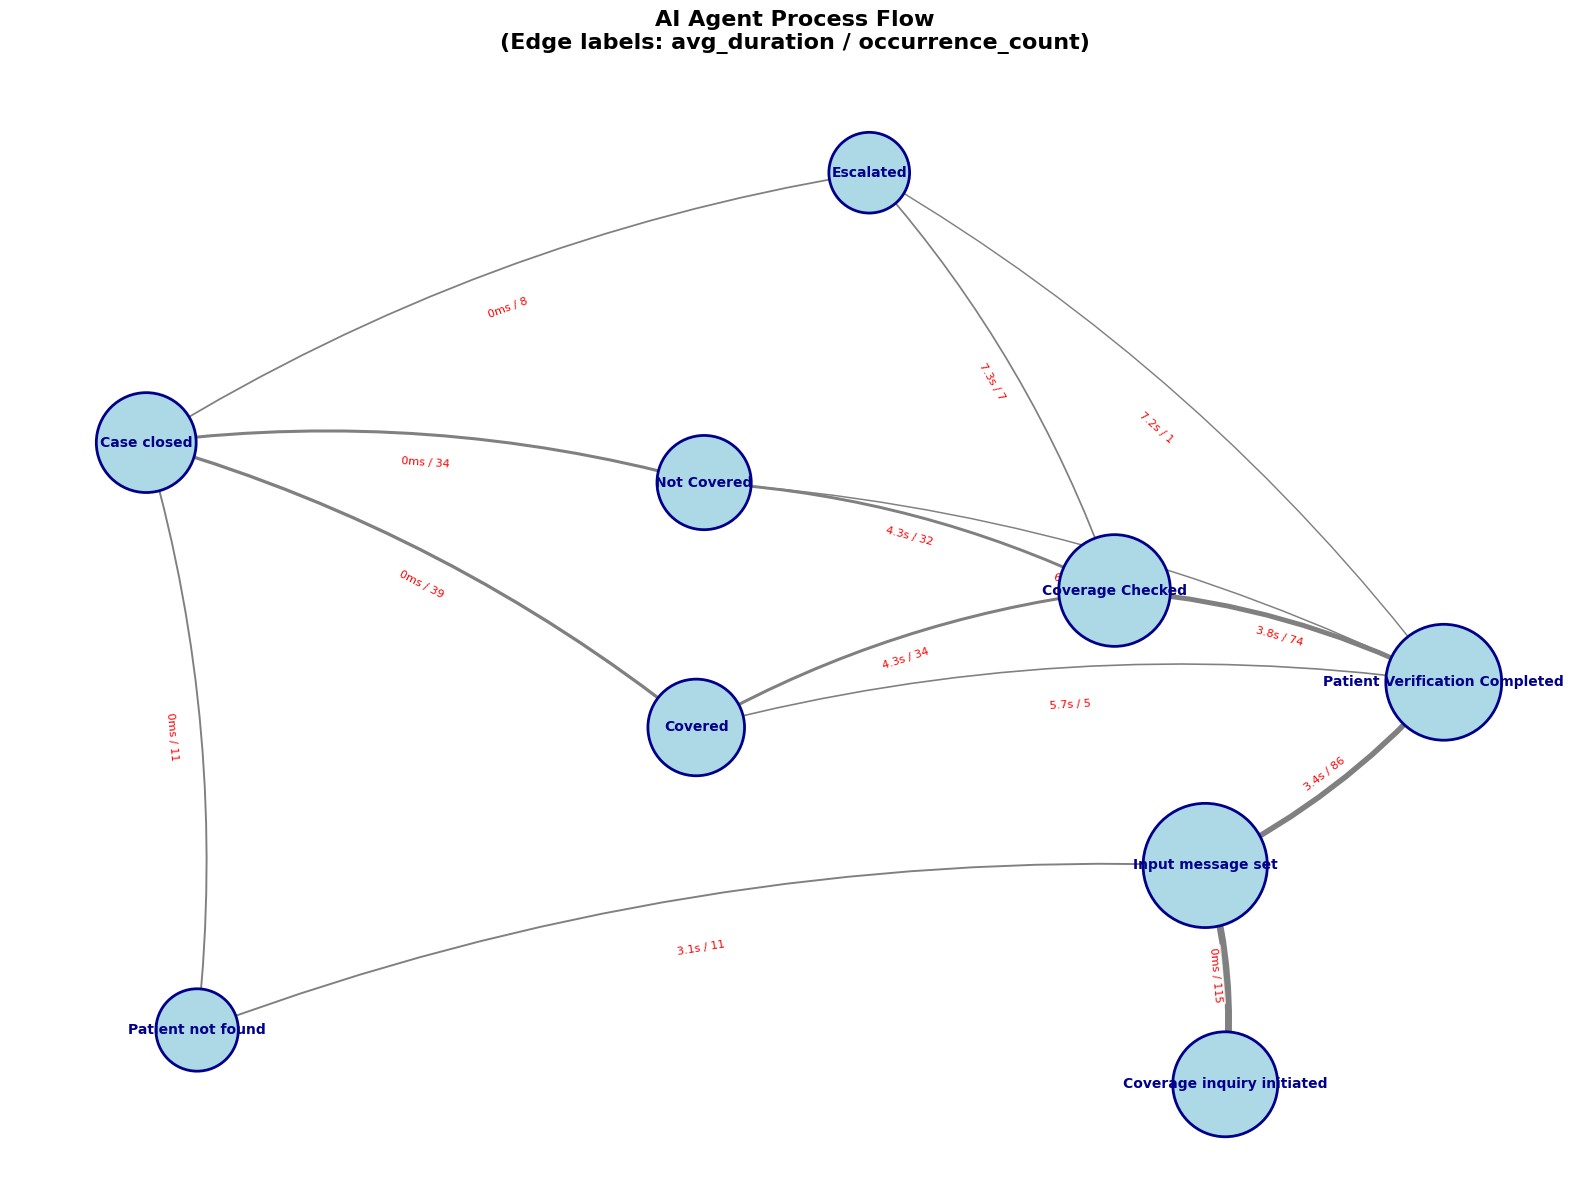


2️⃣ Creating interactive workflow diagram...
✓ Interactive workflow visualization saved to agent_workflow_interactive.html

3️⃣ Creating variant analysis...
✓ Variant analysis visualization saved to variants_analysis.html

4️⃣ Creating bottleneck analysis...
✓ Bottleneck analysis visualization saved to bottlenecks_analysis.html

✅ Complete Analysis Finished!

📂 Generated Files:
   • agent_workflow_static.png
   • agent_workflow_interactive.html
   • variants_analysis.html
   • bottlenecks_analysis.html
✓ Extracted 459 transitions


In [28]:
# =============================================================================
# USAGE EXAMPLE
# =============================================================================
if __name__ == "__main__":

    all_logs = []
    # Path to file with all prompts
    file_path = 'miningAgent/docs/agent_log.csv'

    # Read logs and transform the data
    with open(file_path, mode='r', newline='', encoding='utf-8') as csv_file:
        # Use csv.DictReader to map the header row to keys
        csv_reader = csv.DictReader(csv_file)
        # Iterate over all subsequent rows
        for row in csv_reader:
            # Check if the action is 'Decision Finalized'
            if row.get('action') == 'Decision Finalized':
                comment = row.get('comment', '')

                # This captures any character ([^,]+) after 'decision:' up to a comma,
                # correctly handling multi-word decisions like 'Not Covered'.
                match = re.search(r'decision:\s*([^,]+)', comment)

                if match:
                    # Extract the captured group (the decision value) and strip whitespace
                    decision = match.group(1).strip()
                    # Replace the 'action' field with the final decision
                    row['action'] = decision

            # Append the (potentially modified) row to the list
            all_logs.append(row)

    try:
        tool = ProcessMiningTool(all_logs)

        # Run complete analysis
        tool.run_complete_analysis(
            static_output='agent_workflow_static.png',
            interactive_output='agent_workflow_interactive.html',
            variants_output='variants_analysis.html',
            bottlenecks_output='bottlenecks_analysis.html'
        )

        # Optional: Access individual components
        kpis = tool.compute_kpis()
        transitions = tool.extract_transitions()
        graph = tool.build_process_graph()

    except FileNotFoundError:
        print(f"❌ Error: File '{file_path}' not found!")
        print("Trying with Sample.csv instead...")

        # Example 2: Direct CSV file path (fallback)
        try:
            tool = ProcessMiningTool('Sample.csv')
            tool.run_complete_analysis()
        except FileNotFoundError:
            print("❌ Error: Sample.csv also not found!")
            print("Please ensure a CSV file is available.")

    except Exception as e:
        print(f"❌ Error occurred: {str(e)}")
        import traceback
        traceback.print_exc()
